# 1.bis. CBoW demo (Full text)

### Imports

In [1]:
import torch
import collections
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Step 1. Data Processing

In [2]:
k = 2  # window size
testcase = "f1"

In [3]:
with open(testcase, "r") as f:
    sentences = [[int(x) for x in sentence.strip().split()] for sentence in f.readlines()][1:]
sentences = [[-2]*k + sentence + [-2]*k for sentence in sentences]
sentences = [[x%1024 for x in sentence] for sentence in sentences]

VOCAB_SIZE = 1024  # actually 1000+2

In [4]:
data = []
for sentence in sentences:
    for segment in zip(*[sentence[i:] for i in range(2*k+1)]):
#         if c == 1023:
#             continue
        data.append([[*segment[:k], *segment[-k:]], segment[k]])
print(len(data))

23589


In [5]:
# negative sampling
data_aug = []
freq = collections.Counter([x[1] for x in data])
print(max(freq.values()))
for context, target in data:
    data_aug.extend([[context, target]]*int(200//(freq[target]**0.2)))
len(data_aug), len(data_aug)**0.2

1525


1833765

In [6]:
freq_aug = collections.Counter([x[1] for x in data_aug])
freq_aug[0], freq_aug[100], freq_aug[0]/freq_aug[100]

(60348, 3895, 15.493709884467266)

In [7]:
freq[0], freq[100], freq[0]/freq[100]

(1284, 41, 31.317073170731707)

In [8]:
test_data = []
for sentence in sentences:
    for segment in zip(*[sentence[i:] for i in range(2*k+1)]):
        if segment[k] == 1023:
            test_data.append([*segment[:k], *segment[-k:]])
print(len(test_data))

1525


### Step 2. Create a CBoW model and train

In [9]:
class CBOW(nn.Module):

    def __init__(self, context_size, embedding_size, vocab_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim=0)
        out = self.linear(embeds)
        #out = F.log_softmax(out, dim = -1)
        return out

In [10]:
# Create model and pass to CUDA
model = CBOW(context_size = 2, embedding_size = 20, vocab_size = VOCAB_SIZE)
model = model.to(device)
model.train()

CBOW(
  (embeddings): Embedding(1024, 20)
  (linear): Linear(in_features=20, out_features=1024, bias=True)
)

In [11]:
# Define training parameters
learning_rate = 0.001
epochs = 100
torch.manual_seed(28)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
def measure_accuracy(model):
    model.eval()
    num_correct = 0
    num_data = 0
    for context, target in data:
        if target > 1000:
            continue
        ids = torch.tensor(context)
        output = model(ids)
        result = torch.argmax(output[:-2]).item()
        
        num_data += 1
        if result == target:
            num_correct += 1
    return num_correct/num_data

In [13]:
losses = []
accuracies = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    
    random.shuffle(data_aug)
    for context, target in data_aug[:1000]:
        
        # Prepare data
        ids = torch.tensor(context)
        target = torch.tensor([target])
                
        # Forward pass
        model.zero_grad()
        output = model(ids)
        # Reshape to cover for absence of minibatches (needed for loss function)
        output = torch.reshape(output, (1, VOCAB_SIZE))
        loss = loss_func(output, target)
        
        # Backward pass and optim
        loss.backward()
        optimizer.step()
        
        # Loss update
        total_loss += loss.data.item()
        
    accuracies.append(measure_accuracy(model))
    losses.append(total_loss)
    print(epoch, end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [14]:
model.eval()
results = []
for context in test_data:
    ids = torch.tensor(context)
    output = model(ids)
    result = torch.argmax(output[:-2]).item()  # exclude -1 (mask) and -2 (end)
    results.append(result)

In [15]:
with open("{}.cbow".format(testcase), "w") as f:
    f.write("\n".join([str(result) for result in results]))

### 3. Visualization

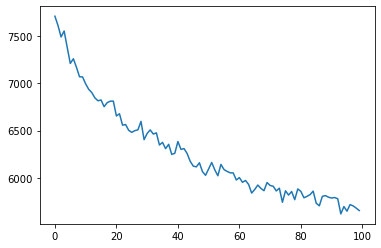

In [16]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

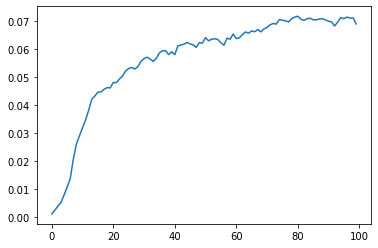

In [17]:
# Display losses over time
plt.figure()
plt.plot(accuracies)
plt.show()

In [18]:
if __name__ == "__main__":
    get_ipython().system('jupyter nbconvert --to script cbow.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook cbow.ipynb to script
[NbConvertApp] Writing 4494 bytes to cbow.py
